In [1]:
import torch
import numpy as np
import models
import data
import pydicom as dicom
import cv2
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
model_path = '/home/tstrebel/models/rnsa/transfer-v1.4.ckpt'
targets_path = '/home/tstrebel/repos/umich-mads-capstone-project/assets/rnsa-targets.csv'
img_dir = '/home/tstrebel/assets/rnsa-pneumonia/train-images/'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

data_dict = data.get_training_data_target_dict(targets_path)
df_test = data_dict['df_test']

del data_dict

df_all = (pd.read_csv('/home/tstrebel/assets/rnsa-pneumonia/stage_2_train_labels.csv.zip')
          .rename({ 'patientId':'patient_id', 'Target':'target' }, axis=1))

neg_class_count, pos_class_count = df_test.target.value_counts().values

dataset = data.get_dataset(img_dir, df_test)

In [3]:
state_dict = torch.load(model_path, map_location=device)['state_dict']
model = models.Densenet121GradCam()
_ = model.load_state_dict(state_dict)

pneumonia
Age 40
Sex F
Probability estimate: 0.9711
Positive prediction threshold 0.3472
Predicted correctly? True


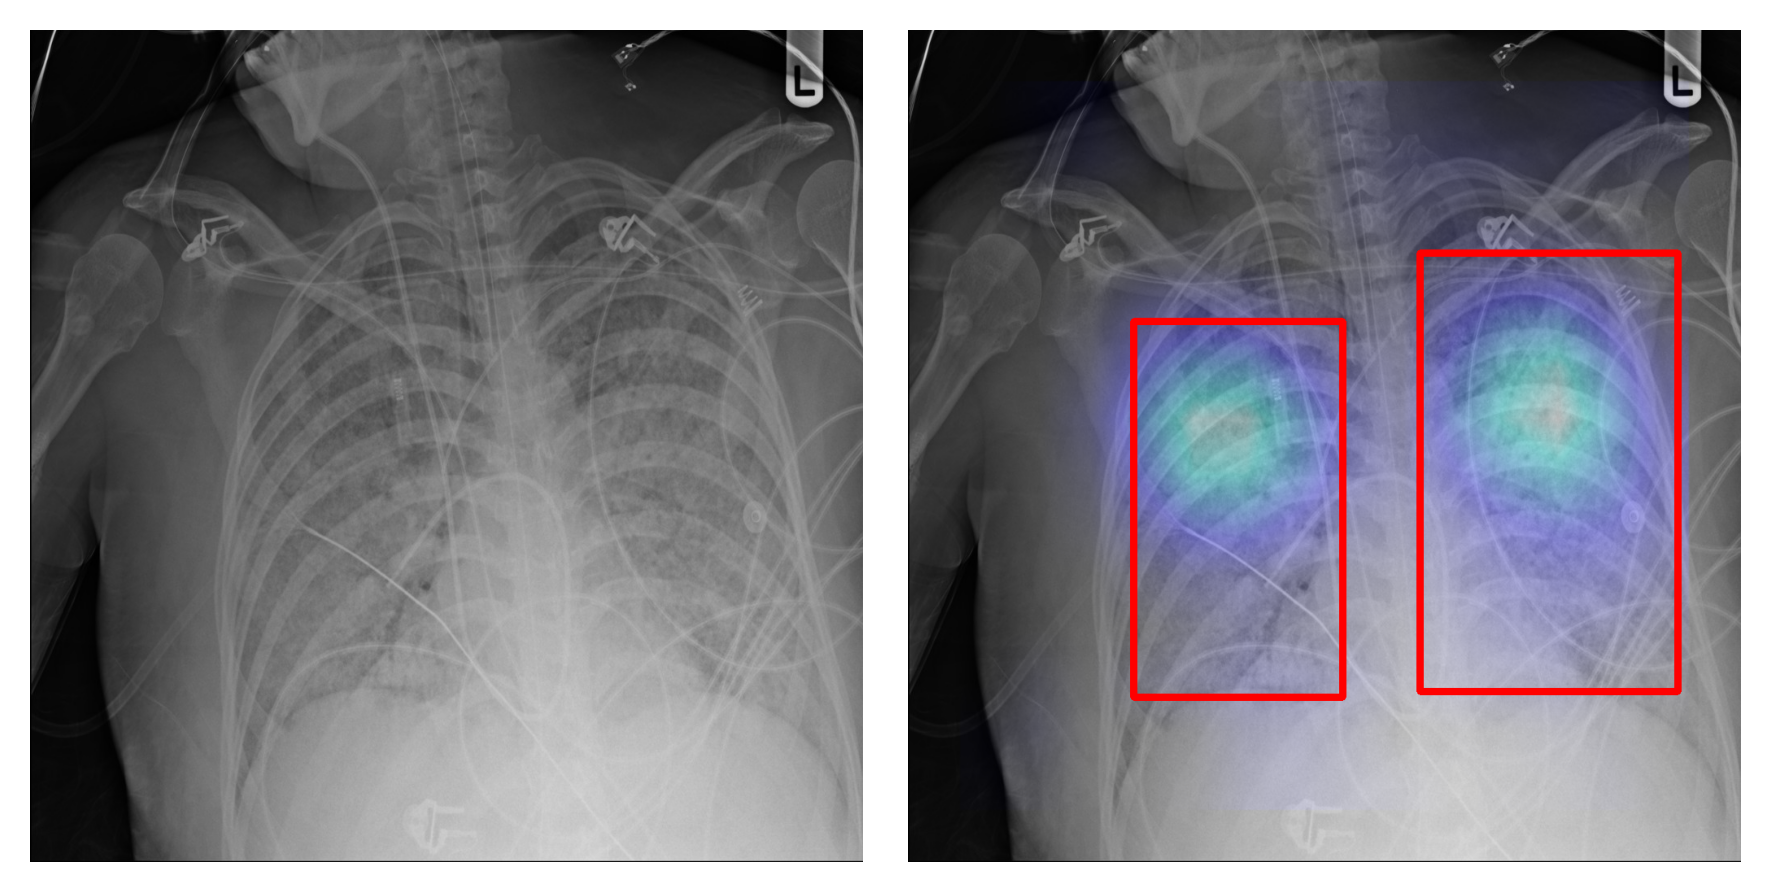

In [46]:
# Implementation adapted from https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82
def show_gradcam(model, patient, target, threshold=.5):
    model.eval()
    inputs, target = dataset[np.where(df_test.index==patient.name)[0][0]]
    inputs = inputs.unsqueeze(dim=0)
    
    outputs = model(inputs)
    
    proba = torch.sigmoid(outputs).item()

    pred = (proba >= threshold)
    
    outputs.backward()
    
    with torch.no_grad():
        # pull the gradients out of the model
        gradients = model.get_activations_gradient()
        # pool the gradients across the channels
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
        # get the activations of the last convolutional layer
        activations = model.get_activations(inputs)
        # weight the channels by corresponding gradients
        for i in range(pooled_gradients.shape[0]):
            activations[:, i, :, :] *= pooled_gradients[i]
        # average the channels of the activations
        heatmap = torch.mean(activations, dim=1).squeeze()
    # relu on top of the heatmap
    # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
    heatmap = np.maximum(heatmap, 0)
    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    img_path = ''.join([img_dir, '/', patient.patient_id, '.dcm'])

    image = dicom.dcmread(img_path)
    
    print(['no-pneumonia', 'pneumonia'][target.int().item()])
    print('Age', image.PatientAge)  
    print('Sex', image.PatientSex)
    print('Probability estimate: {:.4f}'.format(proba))
    print('Positive prediction threshold {:.4f}'.format(threshold))
    print('Predicted correctly?', (pred == target.int()).item())
    
    heatmap_x = cv2.resize(heatmap.numpy(), (448, 448))
    heatmap_x = np.pad(heatmap_x, 32)
    heatmap_x = cv2.resize(heatmap_x, (image.pixel_array.shape[1], image.pixel_array.shape[0]))
    heatmap_x = np.uint8(255 * heatmap_x)
    heatmap_x = cv2.applyColorMap(heatmap_x, cv2.COLORMAP_HOT)
    
    image = cv2.cvtColor(image.pixel_array, cv2.COLOR_GRAY2RGB)
    image_x = cv2.addWeighted(image, 1.0, heatmap_x, .3, 1.0)
    # Draw bounding box
    if target == 1:
        for row in df_all[df_all.patient_id==patient.patient_id].iloc[:, 1:-1].values:
            x, y, w, h = np.int64(row)
            image_x = cv2.rectangle(image_x, (x, y), (x+w, y+h), (255, 0, 0), 7)

    fig, (ax1, ax2) = plt.subplots(ncols=2, dpi=300)
    ax1.imshow(image)
    ax2.imshow(image_x)
    ax1.axis('off')
    ax2.axis('off')
    fig.tight_layout()
    plt.show()

target = 1

if target == 0:
    patient_ix = np.random.randint(0, neg_class_count)
elif target == 1:
    patient_ix = np.random.randint(0, pos_class_count)

patient = df_test[df_test.target==target].iloc[patient_ix]

show_gradcam(model, patient, target, threshold=0.3472)